In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
mercari_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.tsv', sep="\t")
test_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.tsv', sep="\t")

# **피처 정리**

In [12]:
# 상품명에 특수문자가 있는지 여부 및 카운트
mercari_df['name_special'] = mercari_df['name'].str.contains(r"[^A-Za-z\s]", regex=True)
mercari_df['name_special_count'] = mercari_df['name'].str.count(r"[^A-Za-z\s]")
special_list=[]

In [13]:
# 상품명에 숫자가 있는지 여부 및 카운트
mercari_df['name_digit'] = mercari_df['name'].str.contains(r'/d', regex=True)
mercari_df['name_digit_count'] = mercari_df['name'].str.count(r"\d")

In [14]:
# 상품명에 가격[rm] 표시 여부
mercari_df['contains_rm'] = mercari_df['name'].str.contains('[rm]', regex=False)

In [66]:
# 상품 카테고리를 분리하여 상품군을 정리함
category = mercari_df['category_name'].str.split('/', expand=True)
mercari_df['cate1']=category[0]
mercari_df['cate2']=category[1]
mercari_df['cate3']=category[2]

In [23]:
# 제품 설명에 특수문자가 있는지 여부 및 카운트
mercari_df['desc_special'] = mercari_df['item_description'].str.contains(r"[^A-Za-z\s]", regex=True)
mercari_df['desc_special_count'] = mercari_df['item_description'].str.count(r"[^A-Za-z\s]")
special_list=[]

In [24]:
# 제품 설명에 숫자가 있는지 여부 및 카운트
mercari_df['desc_digit'] = mercari_df['item_description'].str.contains(r'/d', regex=True)
mercari_df['desc_digit_count'] = mercari_df['item_description'].str.count(r"\d")

In [20]:
# 제품 설명에 길이와 어절을 확인
mercari_df['desc_len']=mercari_df['item_description'].str.replace('No description yet','').apply(len)
mercari_df['desc_space']=mercari_df['item_description'].str.replace('No description yet','').str.split(r'\s').apply(len)

In [22]:
# 제품 설명에 가격[rm] 표시 여부
mercari_df['desc_rm'] = mercari_df['item_description'].str.contains('[rm]', regex=False)

In [36]:
# 제품 설명이 존재하는지 여부
mercari_df['no_desc'] = (mercari_df['item_description'] == '').astype(int)

In [31]:
#brand/category 결측 여부를 컬럼으로 만들어 금액과 비교.

mercari_df['brand_missing'] = mercari_df['brand_name'].isna().astype(int)
mercari_df['category_missing'] = (mercari_df['category_name'] == 'Unknown').astype(int)

# **브랜드가 결측인 행에서 상품명에 브랜드가 있다면 매핑하고 없으면 unknown으로 처리**

In [25]:
def build_token_brand_map(mercari_df, min_count=20, min_ratio=0.8):
    """
    mercari_df: 전처리된 train 데이터프레임 (name_clean 포함)
    min_count: 해당 토큰으로 등장한 브랜드 수 최소 빈도
    min_ratio: 해당 토큰에서 특정 브랜드가 차지하는 비율 (precision 기준)

    반환:
      tok1_map, tok2_map : {
          토큰 : 대표 브랜드
      } 형태의 dict
    """

    # 1) brand_name 이 존재하는 경우만 학습에 사용
    df_known = mercari_df[~mercari_df["brand_name"].isna()].copy()

    # 2) name_clean 기준으로 토큰 분리
    tokens = df_known["name_clean"].str.split()
    df_known["tok1"] = tokens.str[0]                 # 첫 단어
    df_known["tok2"] = tokens.str[:2].str.join(" ")  # 첫 두 단어

    # 3) tok1/tok2 각각 매핑 생성
    tok_maps = {}

    for col in ["tok1", "tok2"]:
        # (토큰, 브랜드) 조합별 등장 횟수
        grp = (
            df_known
            .groupby([col, "brand_name"])
            .size()
            .reset_index(name="cnt")
        )

        # 해당 토큰의 전체 등장 횟수
        total = grp.groupby(col)["cnt"].sum().reset_index(name="total")
        grp = grp.merge(total, on=col, how="left")

        # ratio = 특정 브랜드가 tok 전체에서 차지하는 비율
        grp["ratio"] = grp["cnt"] / grp["total"]

        # 필터링: 자주 나오고 압도적 비율일 때만 인정
        cond = (grp["cnt"] >= min_count) & (grp["ratio"] >= min_ratio)
        grp_strong = grp[cond].copy()

        # 동일 토큰에 여러 브랜드가 남아 있으면 → 가장 ratio 높은 브랜드만 선택
        grp_strong = (
            grp_strong
            .sort_values(["ratio", "cnt"], ascending=[False, False])
            .drop_duplicates(subset=[col], keep="first")
        )

        # dict 매핑
        tok_maps[col] = dict(zip(grp_strong[col], grp_strong["brand_name"]))

    # 4) 최종 dict 분리
    tok1_map = tok_maps["tok1"]
    tok2_map = tok_maps["tok2"]

    return tok1_map, tok2_map

In [26]:
def fill_brand_by_token_map(mercari_df, tok1_map, tok2_map):
    """
    mercari_df : 브랜드를 채울 대상 데이터프레임 (name_clean, brand_name 포함)
    tok1_map   : 첫 단어(tok1) → 브랜드 매핑 dict
    tok2_map   : 첫 두 단어(tok2) → 브랜드 매핑 dict

    반환:
      brand_filled 컬럼이 추가된 mercari_df 복사본
        - 원래 brand_name 있으면 그대로 유지
        - 결측일 때만 tok2 → tok1 순서로 채움
        - 그래도 없으면 'unknown'
    """
    df = mercari_df.copy()

    # name_clean 기준 토큰 분리
    tokens = df["name_clean"].str.split()
    df["tok1"] = tokens.str[0]                   # 첫 단어
    df["tok2"] = tokens.str[:2].str.join(" ")    # 첫 두 단어

    # 새 컬럼: 기본값은 원래 brand_name (문자열화)
    df["brand_filled"] = df["brand_name"].astype(str)

    # 채울 대상: brand_name 이 NaN 이거나 완전 공백
    mask_missing = df["brand_name"].isna() | (df["brand_name"].astype(str).str.strip() == "")

    # 1순위: tok2 매핑이 있는 경우 (더 정확하니까 먼저)
    mask_tok2 = mask_missing & df["tok2"].isin(tok2_map.keys())
    df.loc[mask_tok2, "brand_filled"] = df.loc[mask_tok2, "tok2"].map(tok2_map)

    # 2순위: 여전히 비어 있는 경우 tok1 매핑 사용
    mask_missing2 = (
        df["brand_filled"].isna()
        | (df["brand_filled"].astype(str).str.strip() == "")
        | (df["brand_filled"] == "nan")
    )
    mask_tok1 = mask_missing2 & df["tok1"].isin(tok1_map.keys())
    df.loc[mask_tok1, "brand_filled"] = df.loc[mask_tok1, "tok1"].map(tok1_map)

    # 그래도 비어 있으면 unknown 으로 통일
    df["brand_filled"] = df["brand_filled"].replace(["", "nan"], "unknown")
    df["brand_filled"] = df["brand_filled"].fillna("unknown")

    # 임시 컬럼 정리
    df = df.drop(columns=["tok1", "tok2"])
    return df

In [29]:
# 1) name_clean 만들기
mercari_df = apply_clean_name(mercari_df)

# 2) 토큰 → 브랜드 매핑 생성 (train 기준)
tok1_map, tok2_map = build_token_brand_map(mercari_df, min_count=20, min_ratio=0.8)

# 3) 브랜드 결측 채우기
mercari_df = fill_brand_by_token_map(mercari_df, tok1_map, tok2_map)

# 4) 결과 확인
mercari_df[["name", "name_clean", "brand_name", "brand_filled"]].head()

,name,name_clean,brand_name,brand_filled
0,MLB Cincinnati Reds T Shirt Size XL,MLB Cincinnati Reds T Shirt Size XL,NaN,unknown
1,Razer BlackWidow Chroma Keyboard,Razer BlackWidow Chroma Keyboard,Razer,Razer
2,AVA-VIV Blouse,AVA VIV Blouse,Target,Target
3,Leather Horse Statues,Leather Horse Statues,NaN,unknown
4,24K GOLD plated rose,24K GOLD plated rose,NaN,unknown


In [34]:
mercari_df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'log_price',
       'category_missing', 'cate1', 'cate2', 'cate3', 'category_count',
       'brand_missing', 'brand_filled_raw', 'name_len', 'name_word_count',
       'desc_len', 'desc_word_count', 'name_special', 'name_special_count',
       'name_digit', 'name_digit_count', 'contains_rm', 'desc_special',
       'desc_special_count', 'desc_digit', 'desc_digit_count', 'desc_rm',
       'has_brand_in_name', 'has_brand_in_desc', 'has_category_in_name',
       'has_category_in_desc', 'full_text', 'full_text_clean', 'name_clean',
       'brand_filled', 'desc_space'],
      dtype='object')

# **TD-IDF**

In [67]:
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# 가격이 0인 경우는 제외하고 로그로 타깃을 변환하기
mercari_df = mercari_df[mercari_df["price"] > 0].copy()
mercari_df["log_price"] = np.log1p(mercari_df["price"])

# 결측치가 있다면 제거하고 문자열로 변환하기
mercari_df["name"] = mercari_df["name"].fillna("").astype(str)
mercari_df["item_description"] = mercari_df["item_description"].fillna("").astype(str)
mercari_df["full_text"] = mercari_df["name"] + " " + mercari_df["item_description"]

def clean_text(s):
    s = s.lower()
    s = re.sub(r"[^0-9a-z\s]", " ", s)   # 영어/숫자/공백만 남기기
    s = re.sub(r"\s+", " ", s).strip()   # 공백 정리
    return s

mercari_df["full_text_clean"] = mercari_df["full_text"].apply(clean_text)

# 2) TF-IDF 벡터화
tfidf = TfidfVectorizer(
    max_features=100_000,   # 상위 10만 개 단어/문구
    ngram_range=(1, 2),     # 1~2그램
    min_df=10)               # 최소 10번 이상 나온 단어만 사용

X_text = tfidf.fit_transform(mercari_df["full_text_clean"])
y_log = mercari_df["log_price"].values

print("TF-IDF shape:", X_text.shape)  # (샘플 수, 단어 수)

ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_text, y_log)
mercari_df["text_pred"] = ridge.predict(X_text)

# 텍스트 모델 성능 확
rmse_log = np.sqrt(mean_squared_error(y_log, mercari_df["text_pred"]))
rmse_price = np.sqrt(
    mean_squared_error(np.expm1(y_log), np.expm1(mercari_df["text_pred"]))
)
print("TF-IDF + Ridge log RMSE :", rmse_log)
print("TF-IDF + Ridge price RMSE :", rmse_price)

from sklearn.metrics import r2_score
mercari_df["text_r2"] = r2_score(y_log, mercari_df["text_pred"])
mercari_df["text_rmse"] = rmse_log

TF-IDF shape: (1481661, 100000)
TF-IDF + Ridge log RMSE : 0.46508034528390807
TF-IDF + Ridge price RMSE : 29.546084857986727


In [69]:
features = [
    'item_condition_id',   # 제품 상태
    'shipping',            # 배송비 지불자
    'brand_filled',        # 자동 보정된 브랜드 < 라벨인코딩
    'cate1', # 카테고리 대분류 < 라벨인코딩
    'cate2', # 카테고리 중분류 < 라벨인코딩
    'cate3', # 카테고리 소분류 < 라벨인코딩
    'name_len',            # 상품명 글자 수 (상관관계 좋은걸로 결정)
    'name_word_count',     # 상품명 단어 수
    'desc_word_count',     # 설명 단어 수
    'desc_len',            # 설명 글자 수
    'brand_missing',       # 브랜드의 유무
    'category_missing',    # 카테고리의 유무
    'no_desc',  # 제품 설명 존재 여부
    'name_special', # 이름에 특수기호 존재 여부
    'name_special_count', # 이름에 특수기호 개수
    'name_digit', # 이름에 숫자 존재 여부
    'name_digit_count', # 이름에 숫자 개수
    'contains_rm', # 이름에 가격[rm](지금은 삭제된) 표시 여부
    'category_count', # 카테고리 수(최소3 최대5)
    'desc_rm', # 설명 가격[rm] 표시 여부
    'desc_special', # 설명 특수기호 존재 여부
    'desc_special_count', # 설명 특수기호 개수
    'desc_digit', # 설명 숫자 존재 여부
    'desc_digit_count', # 설명 숫자 개수
    'text_pred',    # 텍스트(name+item_desc)가 예측한 가격
    'text_r2',     # 그 예측의 신뢰도 (가중치 역할)
    'text_rmse',   # 그 예측의 오차 범위
    'has_category_in_name',  # 이름에 카테고리 포함 여부
    'has_category_in_desc', # 설명에 카테고리 포함 여부
    'has_brand_in_name,', # 이름에 브랜드 존재 여부
    'has_brand_in_desc', # 이름에 설명 존재 여부
]

# 혹시 빠진 컬럼이 있으면 자동으로 제외 (에러 방지용)
features = [f for f in features if f in mercari_df.columns]
print("사용 피처:", features)

사용 피처: ['item_condition_id', 'shipping', 'brand_filled', 'cate1', 'cate2', 'cate3', 'name_len', 'name_word_count', 'desc_word_count', 'desc_len', 'brand_missing', 'category_missing', 'no_desc', 'name_special', 'name_special_count', 'name_digit', 'name_digit_count', 'contains_rm', 'category_count', 'desc_rm', 'desc_special', 'desc_special_count', 'desc_digit', 'desc_digit_count', 'text_pred', 'text_r2', 'text_rmse', 'has_category_in_name', 'has_category_in_desc', 'has_brand_in_desc']


In [71]:
string_cols_to_backup = [col for col in features if mercari_df[col].dtype == 'object']

# "_raw" suffix로 원본 문자열 보관
for col in string_cols_to_backup:
    mercari_df[col + "_raw"] = mercari_df[col].astype(str)

In [72]:
from sklearn.preprocessing import LabelEncoder

# 문자열 dtype인 컬럼은 모두 라벨인코딩
for col in features:
    if mercari_df[col].dtype == 'object':
        print(f"라벨 인코딩 수행: {col}")
        le = LabelEncoder()
        mercari_df[col] = le.fit_transform(mercari_df[col].astype(str))

In [73]:
from sklearn.model_selection import train_test_split

X = mercari_df[features].copy()
y = mercari_df["log_price"].values

# 혹시 bool 타입 있으면 float로 바꿔주기
X = X.astype(float)

# train / valid 나누기 (8:2)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)

# LightGBM 설정
model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=300,      # 트리 개수
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

# 학습
model.fit(X_train, y_train)

# 검증 예측
valid_pred = model.predict(X_valid)

# 로그 스케일 RMSE
rmse_log_lgb = np.sqrt(mean_squared_error(y_valid, valid_pred))
# 실제 가격 스케일 RMSE
rmse_price_lgb = np.sqrt(
    mean_squared_error(np.expm1(y_valid), np.expm1(valid_pred))
)

print("LightGBM log RMSE  :", rmse_log_lgb)
print("LightGBM price RMSE:", rmse_price_lgb)

Train shape: (1185328, 30)
Valid shape: (296333, 30)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1702
[LightGBM] [Info] Number of data points in the train set: 1185328, number of used features: 25
[LightGBM] [Info] Start training from score 2.981011
LightGBM log RMSE  : 0.4414149926721457
LightGBM price RMSE: 27.55469898427962


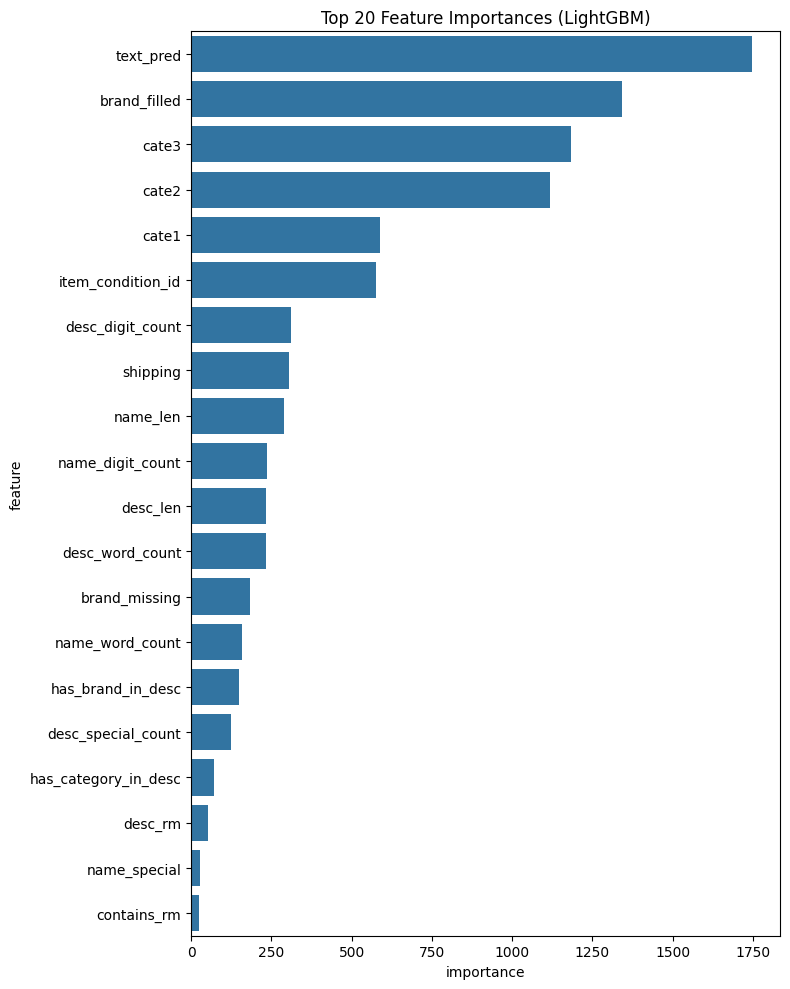

,feature,importance
24,text_pred,1747
2,brand_filled,1343
5,cate3,1182
4,cate2,1118
3,cate1,588
0,item_condition_id,577
23,desc_digit_count,311
1,shipping,306
6,name_len,288
16,name_digit_count,237


In [76]:
fi = pd.DataFrame({
    "feature": features,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(data=fi.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()

fi.head(30)

# **1**
가격을 가장 잘 설명하는 것은 텍스트 기반 예측(text_pred)이고, 그 다음 브랜드, 카테고리, 상태, 설명/이름 기반 텍스트 구조 피처들이었어요.

즉 **설명 방식이 가격 형성에 실제로 큰 영향을 주는 것으로 확인**되었구요.

text_pred는 상품명+설명 문장 전체를 보고 TF-IDF로 확보한 텍스트 기반 가격 감각이라고 하는데 모델이 가장 많이 사용한 피처라는건 텍스트만 봐도 가격이 상당 부분 맞는다는 뜻이라고 해요.

그래서 이름에 어떤 단어가 들어가는지, 설명에 어떤 표현을 쓰는지, 특정 단어들이 가격 패턴을 강하게 만든다는 뜻이라고 볼 수 있다네요.

이 피처만 1500점 이상 중요도로 매우 높게 나와서 설명 요소가 가격 결정에서 가장 중요하다는 증거로도 볼 수 있어요.

# **2**
두번째로는 brand_filled가 2위로 가격 형성에 매우 중요하다고 나왔어요.

브랜드가 존재하는지 그 자체가 가격을 거의 직접적으로 결정하는 강력한 요소라고 볼 수 있어요.

만약 브랜드가 없는 상품이라면... **이미지나 설명을 기반으로 브랜드를 자동 인식해서 추천해주는 비즈니스 아이템**을 만들게 된다면 가격 추천 정확도를 높여줄 수 있겠다고 볼 수 있겠네요.

# **3**
세번째로는 카테고리들이었는데, '여성 > 탑 > 블라우스'처럼 세분화될수록 가격대가 안정적으로 예측이 가능해질 수 있는 구조라고 보면 돼요.

이건 카테고리를 잘 설정하면 가격 추천도가 높아지고 추후 메루카리에서 가격 관련해서 데이터를 더 분석할 때 영향을 끼칠 수 있겠다고 볼 수 있겠어요.

# **4**

그 다음 상품 상태였는데 당연하게도 상태가 좋으면 비싸고, 상태가 나쁘면 싸기 때문에 가격 예측에서 단순하면서도 필수적인 정보였다고 보면 될 것 같아요.

# **5**

그 다음 텍스트 피처들이 많이 보이는데, 제품 설명이나 이름 모두 텍스트가 어떻냐에 따라 가격에 영향을 준다는 뜻으로 보여요.

숫자가 많다는 건 정보가 많다고 볼 수 있으니(단순한 텍스트가 아니니까) 가격이 높아진다고도 볼 수 있고, 설명이 길면(이건 상품 상태에 따라 다르겠지만) 판매자에 대한 신뢰도가 높아져서 가격이 높아질 수도 있고, 이름이 길면 구체적이라고도 볼 수 있으니 가격이 높아질 수도 있겠네요.

저희의 가설과 많이 일치하는 부분이라고 보면 될 것 같아요.

In [77]:
!apt-get -qq -y install fonts-nanum
!fc-cache -fv
!rm -rf /root/.cache/matplotlib

Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory det

In [78]:
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)

### **1. 설명 길이에 따른 평균 가격**

/tmp/ipython-input-1900434034.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('desc_wc_bin')['price']


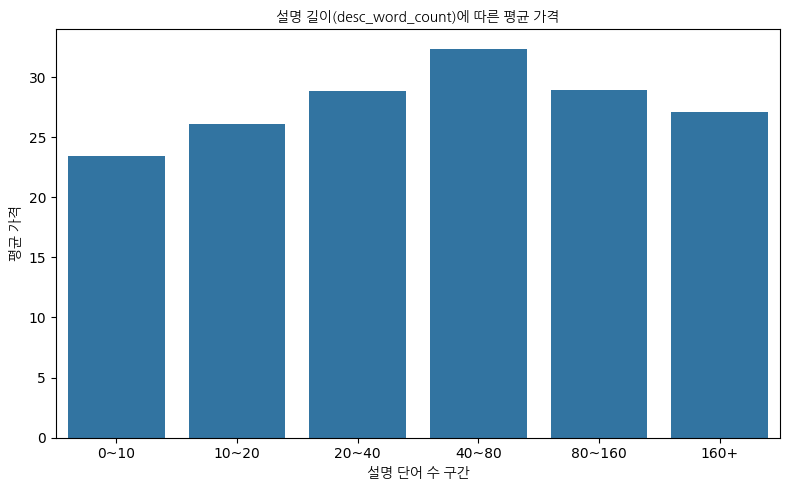

In [84]:
import pandas as pd

# 설명 단어 수 구간 만들기
bins = [0, 10, 20, 40, 80, 160, 10000]
labels = ['0~10', '10~20', '20~40', '40~80', '80~160', '160+']

mercari_df['desc_wc_bin'] = pd.cut(
    mercari_df['desc_word_count'],
    bins=bins, labels=labels, right=False
)

desc_price = (
    mercari_df
    .groupby('desc_wc_bin')['price']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))
sns.barplot(data=desc_price, x='desc_wc_bin', y='price')
plt.xlabel("설명 단어 수 구간", fontproperties=fontprop)
plt.ylabel("평균 가격", fontproperties=fontprop)
plt.title("설명 길이(desc_word_count)에 따른 평균 가격", fontproperties=fontprop)
plt.tight_layout()
plt.show()

위에 보이는 것처럼 설명 단어 수가 너무 짧은 것보다 40~80처럼 어느정도 길게 쓴 상품들이 더 높은 패턴이 보이고 있어요.

desc_word_count가 8번째로 중요했던 이유로 꽤 잘 보여지는 데이터인 것 같아요.

### **2. 제품 상태에 따른 평균 가격**

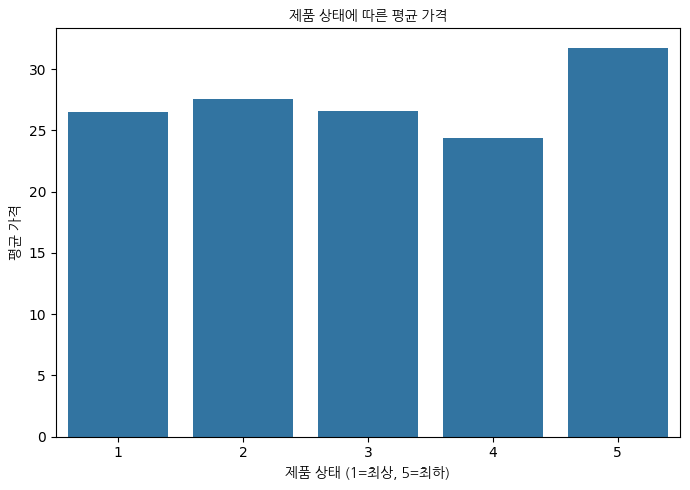

In [85]:
plt.figure(figsize=(7,5))
cond_price = (
    mercari_df
    .groupby('item_condition_id')['price']
    .mean()
    .reset_index()
)

sns.barplot(data=cond_price, x='item_condition_id', y='price')
plt.xlabel("제품 상태 (1=최상, 5=최하)", fontproperties=fontprop)
plt.ylabel("평균 가격", fontproperties=fontprop)
plt.title("제품 상태에 따른 평균 가격", fontproperties=fontprop)
plt.tight_layout()
plt.show()

예상 외로 제품 상태가 좋을 수록 가격이 높을 거라 예상했는데 오히려 최하가 가격이 높은 상황이네요...

상품 상태가 안좋은데 어째서 높은지 브랜드나 카테고리를 조금 들여다봐야 될 것 같아요.

In [88]:
mercari_df[mercari_df['item_condition_id'] == 5]['brand_filled_raw'].value_counts().head(20)

,count
brand_filled_raw,
missing,687
Apple,509
Nintendo,146
Sony,106
Samsung,89
Nike,73
Xbox,36
Louis Vuitton,33
Air Jordan,31


In [90]:
# 카테고리명이 라벨링으로 변환되어서 확인이 불가해 raw 데이터를 추가로 끌어옴
cate_split = mercari_df['category_name'].str.split('/', expand=True)

mercari_df['cate1_raw'] = cate_split[0]
mercari_df['cate2_raw'] = cate_split[1]
mercari_df['cate3_raw'] = cate_split[2]

In [94]:
mercari_df[mercari_df['item_condition_id'] == 5]['cate2_raw'].value_counts().head(20)

,count
cate2_raw,
Cell Phones & Accessories,566
Video Games & Consoles,363
Shoes,255
Computers & Tablets,164
Toys,105
Women's Handbags,102
Jewelry,60
"TV, Audio & Surveillance",60
Women's Accessories,58


In [93]:
mercari_df[mercari_df['item_condition_id'] == 5]['cate3_raw'].value_counts().head(20)

,count
cate3_raw,
Cell Phones & Smartphones,527
Consoles,172
Games,148
Athletic,106
Laptops & Netbooks,78
Other,70
iPad,68
Dolls & Accessories,57
Shoulder Bag,56


여기서 보면 **cell phones, consoles 같은 전자제품들**이 보이나요?

전자제품들은 신제품이거나 새상품일수록 높은 가격대를 웃돌긴 하지만, 지금은 판매하지 않는 제품들(닌텐도, 아이폰 등)은 오히려 빈티지 제품처럼 더 가치가 올라가는 경우들이 많아요.

이럴 경우 상품 상태가 좋지 않아도 가격대가 높아질 수 있기 때문에 이런 경우는 예외 케이스로도 볼 수 있겠네요.

### **3. 제품 상태별 설명 어절 수**

/tmp/ipython-input-3826814826.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


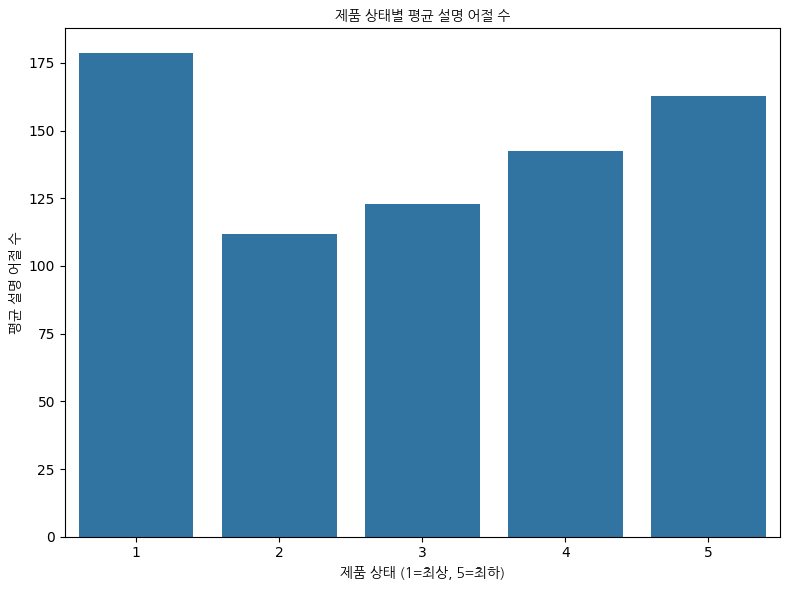

In [95]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=mercari_df,
    x='item_condition_id',
    y='desc_len',
    estimator='mean',
    ci=None
)
plt.xlabel("제품 상태 (1=최상, 5=최하)", fontproperties=fontprop)
plt.ylabel("평균 설명 어절 수", fontproperties=fontprop)
plt.title("제품 상태별 평균 설명 어절 수", fontproperties=fontprop)
plt.tight_layout()
plt.show()

제품 상태에 따른 설명 어절 수를 확인해보았을 때,

- 1 (새 상품) : 가장 설명이 많았음
- 2 ~ 4 (거의 새 것 ~ 보통) : 설명이 줄어듬
- 5 (불량 또는 부품용) : 다시 설명 어절 수 증가

로 확인 되었어요.

    즉, 최고 상태와 최악 상태에서 판매자가 설명을 길게 쓰는 것으로 보여지고 전략적인 형태로 분석할 수 있었어요.

1. 상태가 너무 좋을 때 설명이 많아지는 이유는, 품질 인증과 더불어 어필할 것이 많아서 설명이 길어질 수 있다고 볼 수 있고,
2. 상태가 나쁠 때 설명이 많아지는 이유는 단점을 감추기보단 보완 설명을 해서 구매자들의 신뢰를 얻기 위한 심리로 볼 수 있겠죠?

그래서 오히려 상품의 상태가 중간인 것보단 상태가 좋거나 나쁠 때 설명을 더 많이 할 수 있다고 볼 수 있겠네요.

### **4. 배송 주체별 가격 범위**

/tmp/ipython-input-2120165586.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shipping_counts = mercari_df.groupby(['price_bin_10', 'shipping']).size().unstack(fill_value=0)


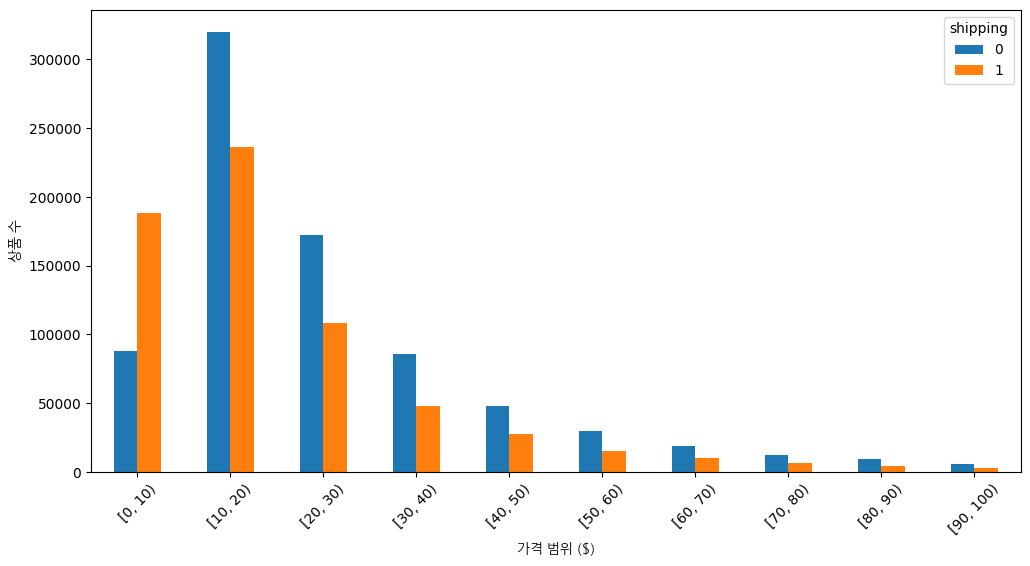

In [99]:
import matplotlib.pyplot as plt
import pandas as pd

# 10달러마다 가격 구간을 생성
mercari_df['price_bin_10'] = pd.cut(
    mercari_df['price'],
    bins=range(0, 110, 10),    # 0,10,20,...100
    right=False)                # [0,10),[10,20) → 0~9, 10~19

# 각 구간별 shipping 개수 세기
shipping_counts = mercari_df.groupby(['price_bin_10', 'shipping']).size().unstack(fill_value=0)

# 그래프
shipping_counts.plot(kind='bar', figsize=(12,6))
plt.xlabel("가격 범위 ($)", fontproperties=fontprop)
plt.ylabel("상품 수", fontproperties=fontprop)
plt.xticks(rotation=45)
plt.show()

가격 범위를 봤을 때 10달러 이전엔 구매자 부담이 매우 낮지만, 그 이후부터 대폭 상승하는 것을 볼 수 있었어요.

이 그래프의 해석은 '매우 저렴한 상품'은 빠르게 판매하고 싶은 판매자들의 가격 경쟁 및 메리트로 인해 오히려 판매자들이 배송을 부담하는 상황이고, 그 이후부턴 판매자들의 부담이 적어들다보니 구매자 부담으로 역전되는 상황이라고 볼 수 있을 것 같아요.

그래서 10달러까진 구매자 부담이 32%고 판매자 부담이 68%였으나, 10달러 이후부터는 구매자 부담이 57%~70%까지 늘어나는 그래프라고 보여지네요.